# 🤖 Modeling Template
Notebook ini digunakan untuk membangun dan mengevaluasi model Machine Learning/Data Mining.

## Langkah yang disarankan:
- Pisahkan data latih dan data uji
- Latih model (misalnya: Decision Tree, Random Forest, SVM, dll.)
- Evaluasi menggunakan metrik: accuracy, precision, recall, F1-score, ROC, confusion matrix

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Baca data hasil preprocessing
df = pd.read_csv('../data/processed/dataset_final.csv')


In [2]:
pip install networkx


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   -------------------- ------------------- 1.0/2.0 MB 3.2 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/2.0 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Hitung frekuensi item (produk)
top_items = df['Description'].value_counts().head(100).index.tolist()



In [9]:

# Filter data hanya yang termasuk dalam 100 produk terbanyak
df_filtered = df[df['Description'].isin(top_items)]

In [10]:
# Group per transaksi
transactions = df_filtered.groupby('InvoiceNo')['Description'].apply(list).tolist()


In [11]:

# One-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [17]:
# ========== APRIORI ==========
frequent_apriori = apriori(df_encoded, min_support=0.02, use_colnames=True)
rules_apriori = association_rules(frequent_apriori, metric="confidence", min_threshold=0.3)

# ==== FILTERING RULE (contoh: lift > 1.2 dan confidence > 0.5) ====
filtered_rules_apriori = rules_apriori[
    (rules_apriori['lift'] > 1.2) & (rules_apriori['confidence'] > 0.5)
]

print("Filtered Rules APRIORI:")
print(filtered_rules_apriori[['antecedents','consequents','support','confidence','lift']].head())


Filtered Rules APRIORI:
                     antecedents                        consequents   support  \
0  (60 TEATIME FAIRY CAKE CASES)  (PACK OF 72 RETROSPOT CAKE CASES)  0.020457   
3    (ALARM CLOCK BAKELIKE PINK)       (ALARM CLOCK BAKELIKE GREEN)  0.021069   
4    (ALARM CLOCK BAKELIKE RED )       (ALARM CLOCK BAKELIKE GREEN)  0.032829   
5   (ALARM CLOCK BAKELIKE GREEN)        (ALARM CLOCK BAKELIKE RED )  0.032829   
7    (ALARM CLOCK BAKELIKE PINK)        (ALARM CLOCK BAKELIKE RED )  0.024683   

   confidence       lift  
0    0.503012   7.889220  
3    0.546900  11.037372  
4    0.590959  11.926565  
5    0.662546  11.926565  
7    0.640700  11.533298  


In [19]:

frequent_fp = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)
rules_fp = association_rules(frequent_fp, metric="confidence", min_threshold=0.3)

# ==== FILTERING RULE ====
filtered_rules_fp = rules_fp[
    (rules_fp['lift'] > 1.2) & (rules_fp['confidence'] > 0.5)
]

print("Filtered Rules FP-GROWTH:")
print(filtered_rules_fp[['antecedents','consequents','support','confidence','lift']].head())

Filtered Rules FP-GROWTH:
                           antecedents                    consequents  \
0          (ALARM CLOCK BAKELIKE RED )   (ALARM CLOCK BAKELIKE GREEN)   
1         (ALARM CLOCK BAKELIKE GREEN)    (ALARM CLOCK BAKELIKE RED )   
3          (ALARM CLOCK BAKELIKE PINK)    (ALARM CLOCK BAKELIKE RED )   
5          (ALARM CLOCK BAKELIKE PINK)   (ALARM CLOCK BAKELIKE GREEN)   
6  (WOODEN PICTURE FRAME WHITE FINISH)  (WOODEN FRAME ANTIQUE WHITE )   

    support  confidence       lift  
0  0.032829    0.590959  11.926565  
1  0.032829    0.662546  11.926565  
3  0.024683    0.640700  11.533298  
5  0.021069    0.546900  11.037372  
6  0.029032    0.530201  10.480142  


In [20]:
# ========== PERBANDINGAN ITEMSETS ==========
common_itemsets = pd.merge(frequent_apriori, frequent_fp, on='itemsets', suffixes=('_apriori', '_fp'))
common_itemsets['support_diff'] = (common_itemsets['support_fp'] - common_itemsets['support_apriori']).abs()
print(f"Itemset sama: {len(common_itemsets)}")
print(f"Itemset beda signifikan (>1%): {len(common_itemsets[common_itemsets['support_diff'] > 0.01])}")


Itemset sama: 149
Itemset beda signifikan (>1%): 0


C:\Users\Infinix\AppData\Local\Temp\ipykernel_9148\2068991595.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Infinix\Downloads\tube_data_mining\tube_data_mining\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


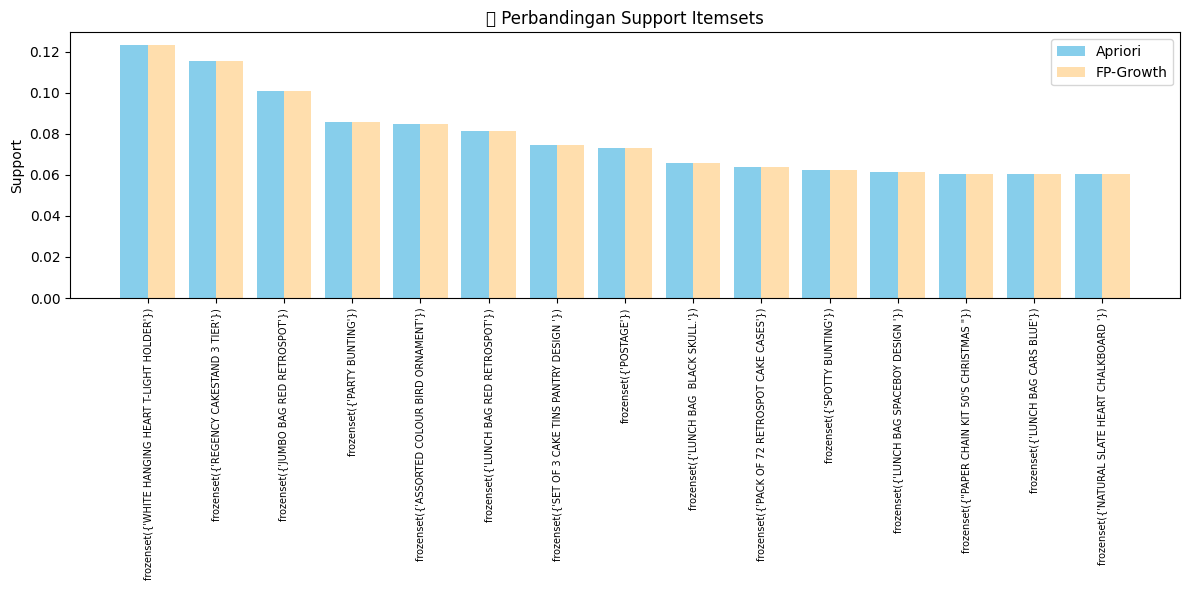

In [22]:

top_n = 15
top_itemsets = common_itemsets.sort_values(by='support_apriori', ascending=False).head(top_n)
x = range(len(top_itemsets))
labels = top_itemsets['itemsets'].astype(str)
support_apriori = top_itemsets['support_apriori']
support_fp = top_itemsets['support_fp']

plt.figure(figsize=(12, 6))
plt.bar(x, support_apriori, width=0.4, label='Apriori', color='skyblue')
plt.bar([i + 0.4 for i in x], support_fp, width=0.4, label='FP-Growth', color='navajowhite')

for i in x:
    diff = support_fp.iloc[i] - support_apriori.iloc[i]
    if abs(diff) > 0.01:
        plt.text(i + 0.2, max(support_apriori.iloc[i], support_fp.iloc[i]) + 0.002,
                 f"{diff:+.1%}", ha='center', fontsize=7)

plt.xticks([i + 0.2 for i in x], labels, rotation=90, fontsize=7)
plt.ylabel("Support")
plt.title("📊 Perbandingan Support Itemsets")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Infinix\AppData\Local\Temp\ipykernel_9148\3168793823.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


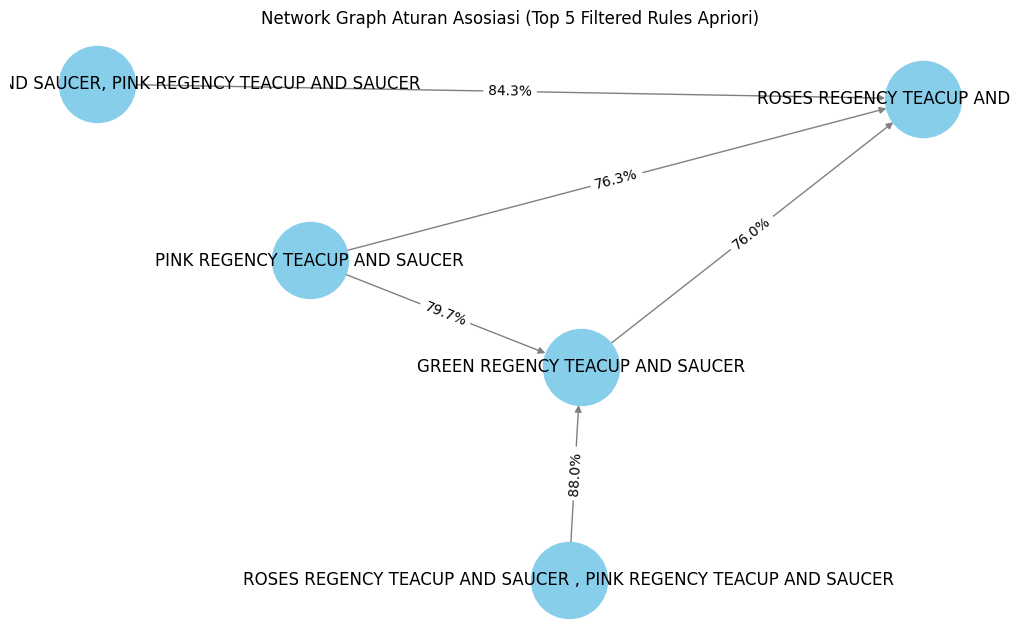

In [23]:
G = nx.DiGraph()
top_rules = filtered_rules_apriori.sort_values(by='confidence', ascending=False).head(5)
for _, row in top_rules.iterrows():
    ant = ', '.join(row['antecedents'])
    con = ', '.join(row['consequents'])
    conf = round(row['confidence'] * 100, 1)
    G.add_edge(ant, con, weight=conf)

pos = nx.spring_layout(G, k=2)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w}%" for u, v, w in G.edges(data='weight')})
plt.title("Network Graph Aturan Asosiasi (Top 5 Filtered Rules Apriori)")
plt.tight_layout()